In [35]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [39]:
def preprocess_scan(scan_path):
    # Load the OCT scan image
    scan = cv2.imread(scan_path)
    
    # Convert the scan to grayscale
    # scan = cv2.cvtColor(scan, cv2.COLOR_BGR2GRAY)

    # Resize the scan to (350, 500) which is roughly the average scan size
    scan = cv2.resize(scan, (500, 350))
    
    return scan

def extract_elm_coords(mask_path):
    # Load the mask image
    mask = cv2.imread(mask_path)

    # Resize the mask to (350, 500)
    mask = cv2.resize(mask, (500, 350))
    
    # Threshold the mask to create a binary image
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    # Find the non-zero pixel coordinates in the binary mask
    elm_coords = np.argwhere(binary_mask > 0)
    
    return elm_coords

def preprocess_data(data_dir):
    scans = []
    elm_coords_list = []
    
    # Iterate through the scans and masks in the data directory
    for scan_file in os.listdir(os.path.join(data_dir, 'scans')):
        scan_path = os.path.join(data_dir, 'scans', scan_file)
        mask_path = os.path.join(data_dir, 'masks', scan_file)
        
        # Preprocess the OCT scan
        scan = preprocess_scan(scan_path)
        scans.append(scan)
        
        # Extract the ELM coordinates from the mask
        elm_coords = extract_elm_coords(mask_path)
        elm_coords_list.append(elm_coords)
    
    return scans, elm_coords_list

# Preprocess the training data
train_scans, train_elm_coords = preprocess_data('/Users/uzaykaradag/Documents/School/Dissertation/gpr-oct-segmentation/data/train')

# Preprocess the testing data
test_scans, test_elm_coords = preprocess_data('/Users/uzaykaradag/Documents/School/Dissertation/gpr-oct-segmentation/data/test')

In [45]:
train_scans[0][0]

array([[ 7,  7,  7],
       [12, 12, 12],
       [ 2,  2,  2],
       ...,
       [15, 15, 15],
       [ 1,  1,  1],
       [ 0,  0,  0]], dtype=uint8)

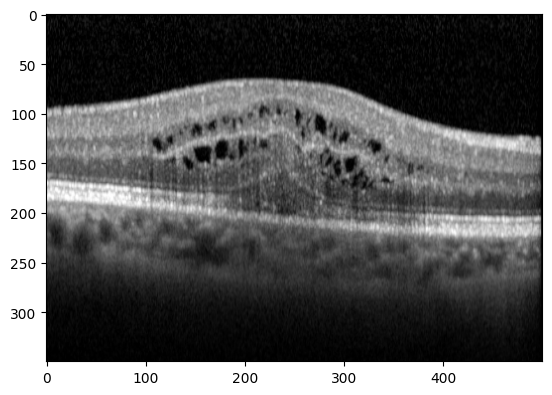

In [47]:
plt.imshow(train_scans[0])

In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from gp_edge_tracing import GP_Edge_Tracing, gpet_utils

def preprocess_scan(scan_path):
    # Load the OCT scan image
    scan = cv2.imread(scan_path)
    # Convert the scan to grayscale
    scan = cv2.cvtColor(scan, cv2.COLOR_BGR2GRAY)
    return scan

def extract_elm_coords(mask_path):
    # Load the mask image
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # Threshold the mask to create a binary image
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    # Find the non-zero pixel coordinates in the binary mask
    elm_coords = np.argwhere(binary_mask > 0)
    return elm_coords

def preprocess_data(data_dir):
    scans = []
    elm_coords_list = []
    # Iterate through the scans and masks in the data directory
    for scan_file in os.listdir(os.path.join(data_dir, 'scans')):
        scan_path = os.path.join(data_dir, 'scans', scan_file)
        mask_path = os.path.join(data_dir, 'masks', scan_file)
        # Preprocess the OCT scan
        scan = preprocess_scan(scan_path)
        scans.append(scan)
        # Extract the ELM coordinates from the mask
        elm_coords = extract_elm_coords(mask_path)
        elm_coords_list.append(elm_coords)
    return scans, elm_coords_list

def predict_elm(scan, elm_coords):
    # Compute the image gradient
    grad_img = gpet_utils.comp_grad_img(scan, gpet_utils.kernel_builder(size=(11, 5)))
    # Initialize the GP_Edge_Tracing instance with default kernel options
    gp_model = GP_Edge_Tracing(init=elm_coords[[0, -1], :][:, [1, 0]], grad_img=grad_img, kernel_options=(1, 3, 3))
    # Predict the ELM line
    predicted_elm_coords = gp_model()
    # Compute the Dice coefficient
    dice_coef = gpet_utils.trace_dicecoef(predicted_elm_coords, elm_coords[:, [1, 0]])
    return scan, predicted_elm_coords, dice_coef

def visualize_elm_prediction(scan, true_elm_coords, predicted_elm_coords, dice_coef):
    plt.figure(figsize=(12, 6))
    plt.imshow(scan, cmap='gray')
    plt.plot(true_elm_coords[:, 1], true_elm_coords[:, 0], 'r-', label='True ELM')
    plt.plot(predicted_elm_coords[:, 0], predicted_elm_coords[:, 1], 'b-', label='Predicted ELM')
    plt.title(f'ELM Prediction (Dice Coefficient: {dice_coef:.4f})')
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Preprocess the training data
train_scans, train_elm_coords = preprocess_data('/Users/uzaykaradag/Documents/School/Dissertation/gpr-oct-segmentation/data/train')

# Predict the ELM line and compute the Dice coefficient
scan, predicted_elm, dice_coef = predict_elm(train_scans[0], train_elm_coords[0])
print(f'Dice Coefficient: {dice_coef}')

Dice Coefficient: 0.6762
